In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns         
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler


In [2]:
df = pd.read_excel('AirQualityUCI.xlsx')

In [3]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [4]:
df.shape

(9357, 15)

In [5]:
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str), dayfirst=True, errors='coerce')
df = df.sort_values('Datetime').reset_index(drop=True)
df = df.drop(columns=['Date','Time'])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CO(GT)         9357 non-null   float64       
 1   PT08.S1(CO)    9357 non-null   float64       
 2   NMHC(GT)       9357 non-null   int64         
 3   C6H6(GT)       9357 non-null   float64       
 4   PT08.S2(NMHC)  9357 non-null   float64       
 5   NOx(GT)        9357 non-null   float64       
 6   PT08.S3(NOx)   9357 non-null   float64       
 7   NO2(GT)        9357 non-null   float64       
 8   PT08.S4(NO2)   9357 non-null   float64       
 9   PT08.S5(O3)    9357 non-null   float64       
 10  T              9357 non-null   float64       
 11  RH             9357 non-null   float64       
 12  AH             9357 non-null   float64       
 13  Datetime       3597 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(12), int64(1)
memory usage: 1023.6 KB


In [6]:
df.replace(-200, np.nan, inplace=True)
df.isna().sum()

CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
Datetime         5760
dtype: int64

In [9]:
df = df.set_index('Datetime')

In [10]:
df = df[~df.index.isna()]

In [11]:
df = df.interpolate(method='time', limit_direction='both')

In [12]:
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

In [13]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)

In [14]:
df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,hour,dayofweek,month,is_weekend
Datetime,,,,,,,,,,,,,,,,,
2004-01-04 00:00:00,1.6,1143.00,106.0,6.291887,825.25,96.0,985.50,86.0,1477.25,978.25,11.950,61.624999,0.859344,0,6,1,1
2004-01-04 01:00:00,1.2,1043.75,100.0,5.121191,769.50,85.0,1031.25,70.0,1424.75,944.25,11.500,63.875000,0.865156,1,6,1,1
2004-01-04 02:00:00,1.1,1034.00,71.0,4.086652,715.50,50.0,1085.00,55.0,1405.00,891.25,10.675,67.224998,0.862988,2,6,1,1
2004-01-04 03:00:00,0.9,956.25,72.0,4.045717,713.25,53.5,1098.50,52.0,1421.50,848.75,8.975,73.100000,0.839403,3,6,1,1
2004-01-04 04:00:00,0.7,909.25,44.0,2.433638,615.00,57.0,1237.00,49.0,1321.50,789.50,10.225,66.575000,0.829898,4,6,1,1


In [15]:
for lag in [1,2,3,24]:   
    df[f'CO_lag_{lag}'] = df['CO(GT)'].shift(lag)
df['CO_roll_3'] = df['CO(GT)'].rolling(window=3, min_periods=1).mean()

In [17]:
pollutants = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'NMHC(GT)']

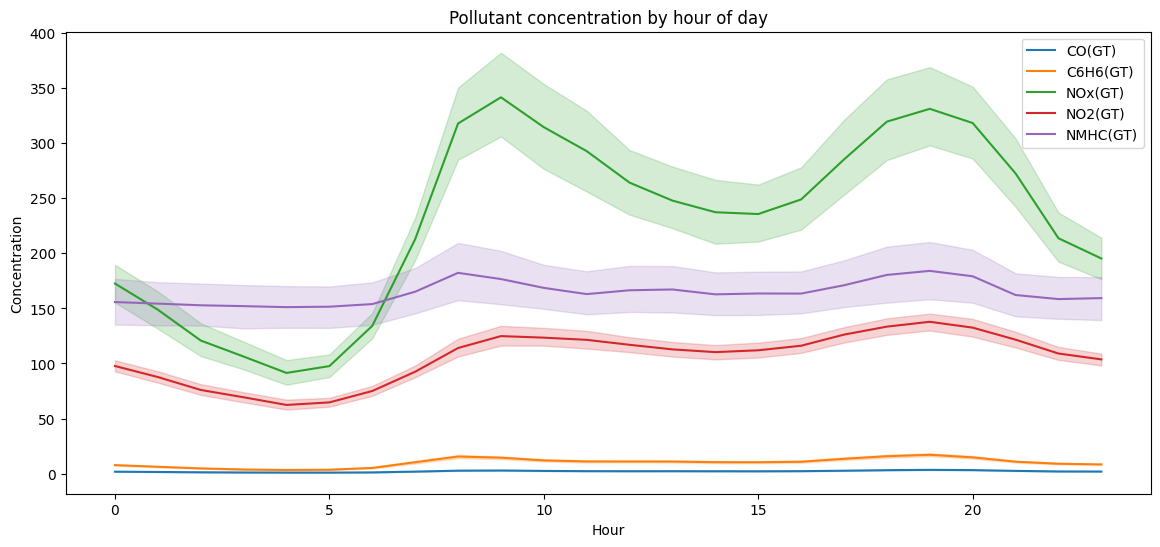

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,6))
for col in pollutants:
    sns.lineplot(x=df.index.hour, y=df[col], label=col)
plt.title('Pollutant concentration by hour of day')
plt.xlabel('Hour')
plt.ylabel('Concentration')
plt.legend()
plt.show()


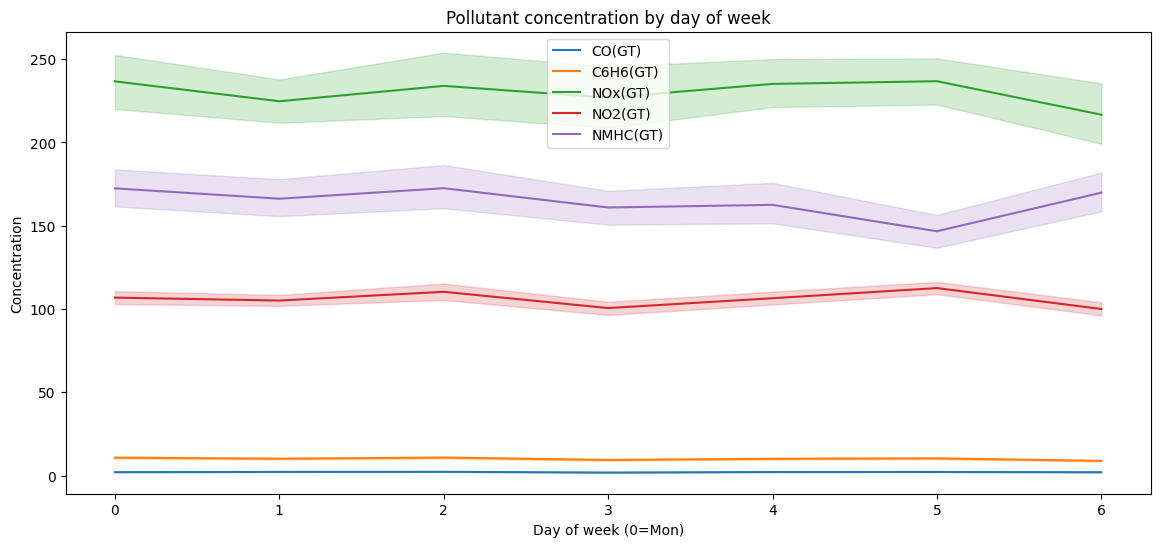

In [19]:
plt.figure(figsize=(14,6))
for col in pollutants:
    sns.lineplot(x=df.index.dayofweek, y=df[col], label=col)
plt.title('Pollutant concentration by day of week')
plt.xlabel('Day of week (0=Mon)')
plt.ylabel('Concentration')
plt.legend()
plt.show()

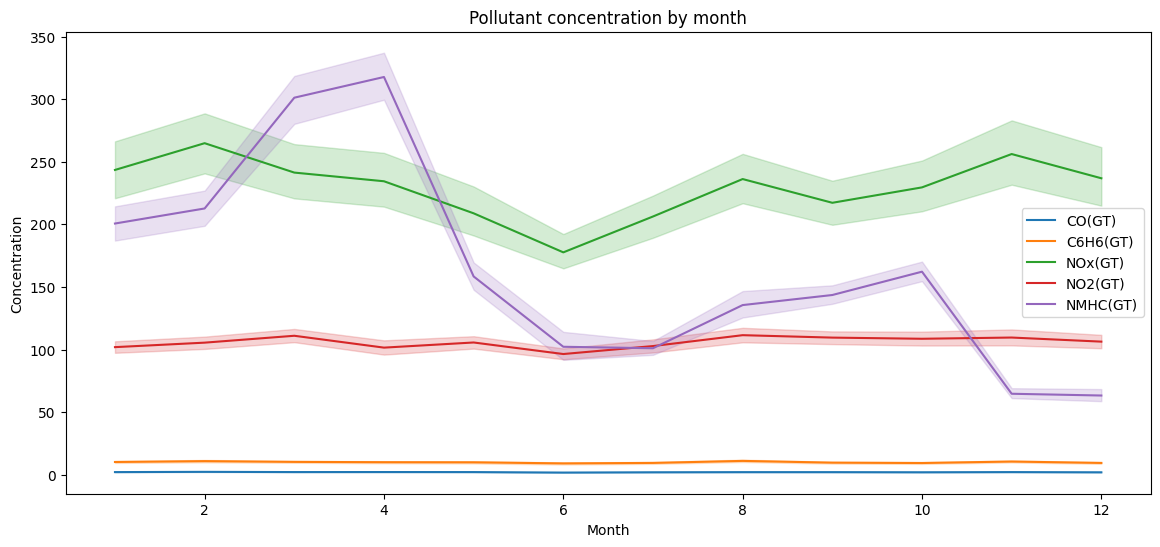

In [20]:
plt.figure(figsize=(14,6))
for col in pollutants:
    sns.lineplot(x=df.index.month, y=df[col], label=col)
plt.title('Pollutant concentration by month')
plt.xlabel('Month')
plt.ylabel('Concentration')
plt.legend()
plt.show()

In [21]:
# Example: train = data before Jan 1, 2005; test = data from Jan 1, 2005 onwards
train = df[df.index < '2005-01-01']
test = df[df.index >= '2005-01-01']

# Features and target
features = ['PT08.S1(CO)','PT08.S2(NMHC)','PT08.S3(NOx)','PT08.S4(NO2)','PT08.S5(O3)',
            'T','RH','AH','hour','dayofweek','CO_lag_1','CO_roll_3']
X_train = train[features]
y_train = train['CO(GT)']
X_test  = test[features]
y_test  = test['CO(GT)']

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print('RMSE:', rmse)
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAE: ', mean_absolute_error(y_test, y_pred))

RMSE: 0.49630163966553764
MAE:  0.312229594106041


In [26]:
from sklearn.metrics import r2_score

# y_test = actual values
# y_pred = predicted values from your model
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)


R-squared: 0.869920334312458


In [28]:
from sklearn.model_selection import train_test_split

target = 'CO(GT)'
features = ['PT08.S1(CO)','PT08.S2(NMHC)','PT08.S3(NOx)',
            'PT08.S4(NO2)','PT08.S5(O3)','T','RH','AH','hour','dayofweek']

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

param_grids = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
        }
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5, 10]
        }
    }
}

In [33]:
best_models = {}
results = {}

for name, config in param_grids.items():
    print(f"🔍 Tuning {name}...")
    grid = GridSearchCV(config['model'], config['params'], cv=3,
                        scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_models[name] = grid.best_estimator_
    y_pred = grid.best_estimator_.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'Best Params': grid.best_params_,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

pd.DataFrame(results).T


🔍 Tuning Linear Regression...
🔍 Tuning Random Forest...
🔍 Tuning Decision Tree...


,Best Params,RMSE,MAE,R2
Linear Regression,{},0.512511,0.439674,0.658746
Random Forest,"{'max_depth': 20, 'min_samples_split': 2, 'n_e...",0.336124,0.369315,0.776193
Decision Tree,"{'max_depth': 5, 'min_samples_split': 5}",0.454008,0.433242,0.6977
